# Assembling a FCN network

## Download data

!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/leaf-segmentation-dataset.zip -o leaf-segmentation-dataset.zip

!unzip leaf-segmentation-dataset.zip

## Load and inspect data

Data is given to you in a `trainval/` and `test/` subdir. Images are named `*_rgb.png` while their foreground masks (_what does this mean?_) are given in `*_fg.png`.

Use this section to figure out what you need / want to know about the data.

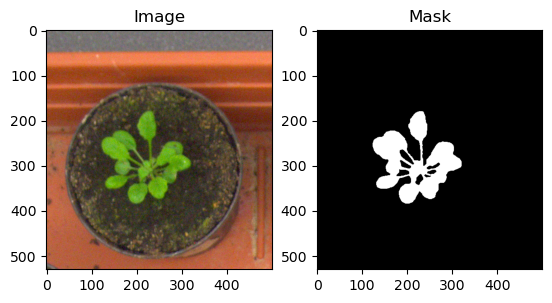

Image size: (500, 530), Mask size: (500, 530)


In [2]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "modified-leaf-segmentation-dataset/test/images/plant (1).png"
mask_path = "modified-leaf-segmentation-dataset/test/masks/plant (1).png"

image = Image.open(image_path)
mask = Image.open(mask_path)

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

print(f"Image size: {image.size}, Mask size: {mask.size}")

## Create your dataset and dataloaders

You've done the Pytorch 60 mins blitz right? Implement your dataset and dataloaders here. From the `trainval/` folder, split your data in an 80/20 split so that you have a train dataset and a validation dataset from this folder. Load your test dataset from `test/`.

You can test the shape of your tensors in the dataset like so:

```python
batch_X, batch_y = next(iter(train_dataset))
print(batch_X.shape, batch_y.shape)
```

Make sure your shape output makes sense!

In [59]:
import random
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

train_image_dir = Path("modified-leaf-segmentation-dataset/trainval/images")
train_mask_dir = Path("modified-leaf-segmentation-dataset/trainval/masks")

filenames = list(train_image_dir.glob("*"))
filenames = [f for f in filenames if f.is_file()] #ensure we only have files

random.seed(42)
random.shuffle(filenames)

#80/20 split
split = int(0.8 * len(filenames))
train_files = filenames[:split]
val_files = filenames[split:]

class LeafDataset(torch.utils.data.Dataset):
    def __init__(self, files, image_dir, mask_dir, image_size=(512, 512)):
        self.files = files
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = transforms.Resize(image_size)
        self.mask_transform = transforms.Resize(image_size, interpolation=Image.NEAREST)

    def __getitem__(self, idx):
        img_path = self.image_dir / self.files[idx].name
        mask_path = self.mask_dir / self.files[idx].name

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") #grayscale

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        #convert to tensors
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        return image, mask

    def __len__(self):
      return len(self.files)

train_dataset = LeafDataset(train_files, train_image_dir, train_mask_dir)
val_dataset = LeafDataset(val_files, train_image_dir, train_mask_dir)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

batch_X, batch_y = next(iter(train_loader))
print(batch_X.shape, batch_y.shape)

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


## Create the network

Define an FCN network by completing the class definition below.

Use a ResNet34 pretrained on ImageNet as the backbone, taking care to remove the final pooling layer and dense layer.

Make sure that the FCN head's tensor input size is the same as the backbone's output size.

Specify the FCN head with two layers:
+ a 1x1 convolution layer, to transform the number of output channels into the number of segmentation classes
+ a transpose convolution layer to upsample the feature maps to the size of the input image. Add a bilinear interpolation here if you need it (I did not work out the math on the image sizing, that's left to you)

In [60]:
from torch import nn
import torchvision.models as models

In [61]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  #remove avgpool and fc (last 2 layers)
        self.conv1x1 = nn.Conv2d(512, num_classes, kernel_size=1, bias=False)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        original_size = x.shape[2:]
        x = self.backbone(x)
        x = self.conv1x1(x)
        x = self.upsample(x)  #upsample to original input size

        if x.shape[2:] != original_size:
            x = nn.functional.interpolate(x, size=original_size, mode='bilinear', align_corners=False)
        return x

In [62]:
model = FCN(num_classes=1).to("cuda")

input_tensor = torch.randn(4, 3, 512, 512).to("cuda")
output = model(input_tensor)

print(output.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 1, 512, 512])


## Verify that you can load a single image and pass it through the network

Neural networks are like a system of pipes. This section is here as a sanity check to ensure that your layers are assembled correct enough for information to flow from top to bottom before you do anything more.

Also, have you taken care of ImageNet normalization and the variable image sizes in the dataset?

In [63]:
print(model(next(iter(train_loader))[0].to("cuda")).shape)

torch.Size([4, 1, 512, 512])


## Obtain a baseline performance of your FCN network

Select an appropriate metric to gauge your FCN network's performance, then measure baseline performance on the testing set. Your FCN head is untrained at this point, so its performance should not be flattering. But you'll change that in the next section!

In [64]:
from torchvision import transforms

test_image_dir = Path("modified-leaf-segmentation-dataset/test/images")
test_mask_dir = Path("modified-leaf-segmentation-dataset/test/masks")
test_files = list(test_image_dir.glob('*'))
test_dataset = LeafDataset(test_files, test_image_dir, test_mask_dir, image_size=(512, 512))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [65]:
model.eval()

baseline_iou = 0.0
count = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        for pred, mask in zip(preds, masks):
            intersection = (pred * mask).sum()
            union = (pred + mask).sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            baseline_iou += iou.item()
            count += 1

mean_iou = baseline_iou / count
print(f"Test Mean IoU: {mean_iou:.4f}")

Test Mean IoU: 0.2062


## Finetuning

Finetune this FCN network using data in `leaf-segmentation-dataset/trainval`. Store the following info every 10 minibatches: loss (choose an appropriate loss function), intersection over union (Jaccard's index), and Dice loss. During training, collect the above metrics on both your train dataset and your validation dataset. When you are done training, check your network performance on your test dataset.

Make sure you are running on GPU! Use Google Colab if you don't have access to a GPU computer. Will leave it to you on exactly how you want to implement finetuning. Run finetuning that will finish within 15, 20 minutes, don't need to finetune for too long.

In [66]:
from torch import optim

In [67]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_metrics, val_metrics = [], []

In [68]:
for epoch in range(20):
    model.train()
    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #every 10 batches
        if (batch_idx + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                #compute metrics on current batch (training)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                train_iou = (preds * masks).sum() / (
                    (preds + masks).sum() - (preds * masks).sum() + 1e-6
                )
                train_dice = (2 * (preds * masks).sum()) / (
                    preds.sum() + masks.sum() + 1e-6
                )

                #compute val metrics
                val_loss_total = 0
                val_iou_total = 0
                val_dice_total = 0
                cnt = 0
                for v_images, v_masks in val_loader:
                    v_images, v_masks = v_images.to("cuda"), v_masks.to("cuda")
                    v_out = model(v_images)
                    v_loss = criterion(v_out, v_masks)

                    v_probs = torch.sigmoid(v_out)
                    v_preds = (v_probs > 0.5).float()
                    v_iou = (v_preds * v_masks).sum() / (
                        (v_preds + v_masks).sum() - (v_preds * v_masks).sum() + 1e-6
                    )
                    v_dice = (2 * (v_preds * v_masks).sum()) / (
                        v_preds.sum() + v_masks.sum() + 1e-6
                    )

                    val_loss_total += v_loss.item()
                    val_iou_total += v_iou.item()
                    val_dice_total += v_dice.item()
                    cnt += 1

                avg_val_loss = val_loss_total / cnt
                avg_val_iou = val_iou_total / cnt
                avg_val_dice = val_dice_total / cnt

                train_metrics.append({
                    'loss': loss.item(),
                    'iou': train_iou.item(),
                    'dice': train_dice.item()
                })
                val_metrics.append({
                    'loss': avg_val_loss,
                    'iou': avg_val_iou,
                    'dice': avg_val_dice
                })
                print("Train Metrics:")
                print(train_metrics[-1])
                print("Val Metrics:")
                print(val_metrics[-1])
                print("\n")
            model.train()


Train Metrics:
{'loss': 0.41314011812210083, 'iou': 0.5442327857017517, 'dice': 0.7048584818840027}
Val Metrics:
{'loss': 0.41299824323505163, 'iou': 0.22625388119922718, 'dice': 0.3559631597454427}


Train Metrics:
{'loss': 0.1409173607826233, 'iou': 0.7805973291397095, 'dice': 0.8767814040184021}
Val Metrics:
{'loss': 0.29312947764992714, 'iou': 0.4909384362399578, 'dice': 0.6339720857213251}


Train Metrics:
{'loss': 0.1377490609884262, 'iou': 0.84572434425354, 'dice': 0.9164146184921265}
Val Metrics:
{'loss': 0.27621393371373415, 'iou': 0.5595005001523532, 'dice': 0.6839428924722597}


Train Metrics:
{'loss': 0.10516288876533508, 'iou': 0.7827090620994568, 'dice': 0.8781119585037231}
Val Metrics:
{'loss': 0.2011378724128008, 'iou': 0.6771428529173136, 'dice': 0.7970739686861634}


Train Metrics:
{'loss': 0.12232649326324463, 'iou': 0.8286829590797424, 'dice': 0.9063166975975037}
Val Metrics:
{'loss': 0.11649366491474211, 'iou': 0.7012681128690019, 'dice': 0.808187433052808}


Train

In [69]:
torch.save(model.state_dict(), "fcn_model.pth")

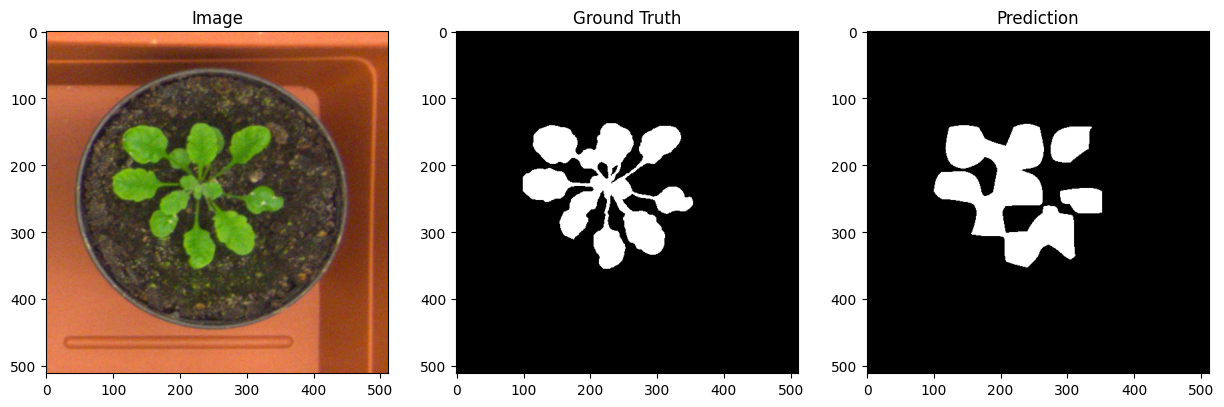

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


In [70]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    outputs = model(images.to("cuda"))
    probs = torch.sigmoid(outputs).cpu()
    preds = (probs > 0.5).float()

    # Plot first image in batch
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[0].permute(1, 2, 0))
    axes[0].set_title("Image")
    axes[1].imshow(masks[0][0], cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[2].imshow(preds[0][0], cmap='gray')
    axes[2].set_title("Prediction")
    plt.show()

print(images.shape, masks.shape)

In [71]:
test_iou = 0.0
count = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        for pred, mask in zip(preds, masks):
            intersection = (pred * mask).sum()
            union = (pred + mask).sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            test_iou += iou.item()
            count += 1

mean_iou = test_iou / count
print(f"Test Mean IoU: {mean_iou:.4f}")

Test Mean IoU: 0.6351


## Writeup

Summarize what you did above, as well as detail the choices you made and why. Concise descriptions in one paragraph is enough :)

First of all, I changed my dataset folder structure to as such, because I am more familiar working with datasets in the YOLO structure (double-click to actually see how this tree looks like)

modified-leaf-segmentation-dataset/
    ├── test/
    │   ├── images/
    │   │   ├── plant (1)
    │   │   ├── plant (2)
    │   │   └── ...
    │   └── masks/
    │       ├── plant (1)
    │       ├── plant (2)
    │       └── ...
    └── trainval/
        ├── images/
        │   ├── plant (1)
        │   ├── plant (2)
        │   └── ...
        └── masks/
            ├── plant (1)
            └── plant (2)

Also I ran the training and inference on Google Colab's T4 GPU so I used .to("cuda"), initially I was using my laptop's Intel GPU so it was .to("xpu")

1) I split the dataset into 80% of trainval for training, and 20% for validation

2) I loaded the pretrained ResNet34, I removed the last 2 layers - avgpool (downsamples by dividing the input into sections and then getting the average value of each section) FC (used to calculate class scores but since we are extracting the background we don't need that) by using "nn.Sequential(*list(backbone.children())[:-2])"

3) Getting the baseline performance, I got the model to iterate through all the test images and then get the average IoU score

4) Initially, I resized the masks using "transforms.Resize" but I read from the internet that it blurs the mask edges (has values in between 0 and 1) and leads to wrong training labels. Then I changed it to "interpolation=Image.NEAREST" and it seems to be better now because the values are now either 0 for black, or 255 for white.

5) Currently still trying to figure out why the test IoU is so low, although the training and validation IoU, and other metrics shows good signs.

## EX: Residual pathways

Here's something for you if you want to explore further.

FCNs are very simple and have some key architectural limitations. Depending on how your structured your network or processed your images, you might hit a performance limit even in this fairly simple dataset, even if you implement aggressive augmentations (_what's that?_). Try circumventing these limitations by implementing residual connections (_google me!_) in your network.

To add skip connections, modify the FCNHead to include features from intermediate ResNet layers (e.g., layer3 and layer4 outputs). Combine them via element-wise addition or concatenation before upsampling. This mimics architectures like FCN-8s, improving fine-grained segmentation.